In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, num_nodes, d_model=128, nhead=8, num_layers=3):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(num_nodes, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, num_nodes)

    def forward(self, src):
        src = self.embedding(src) * np.sqrt(src.size(1))
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


In [ ]:
def generate_synthetic_sequences(num_sequences, sequence_length, num_nodes):
    sequences = []
    for _ in range(num_sequences):
        seq = np.random.permutation(num_nodes)
        sequences.append(seq)
    return np.array(sequences)


In [ ]:
# Parameters
num_nodes = 20
num_sequences = 1000
sequence_length = num_nodes

# Generate synthetic sequences
sequences = generate_synthetic_sequences(num_sequences, sequence_length, num_nodes)
sequences = torch.tensor(sequences, dtype=torch.long)

# Model, Loss, Optimizer
model = TransformerModel(num_nodes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
batch_size = 32

for epoch in range(epochs):
    permutation = torch.randperm(sequences.size(0))
    sequences = sequences[permutation]
    for i in range(0, sequences.size(0), batch_size):
        batch = sequences[i:i+batch_size]
        input_seq = batch[:, :-1]  # All nodes except the last
        target_seq = batch[:, 1:]  # All nodes except the first
        optimizer.zero_grad()
        output = model(input_seq)
        # Reshape for loss computation
        output = output.reshape(-1, num_nodes)
        target_seq = target_seq.reshape(-1)
        loss = criterion(output, target_seq)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Loss: 3.0013
Epoch 2/10, Loss: 3.0037
Epoch 3/10, Loss: 3.0185
Epoch 4/10, Loss: 2.9841
Epoch 5/10, Loss: 2.9746
Epoch 6/10, Loss: 2.9734
Epoch 7/10, Loss: 2.9399
Epoch 8/10, Loss: 2.9828
Epoch 9/10, Loss: 2.9767
Epoch 10/10, Loss: 2.9781


In [ ]:
class AntColonyOptimizer:
    def __init__(self, num_nodes, distance_matrix, num_ants=10, alpha=1.0, beta=2.0, gamma=0.5, evaporation_rate=0.5, Q=100):
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.pheromone = np.ones((num_nodes, num_nodes))
        self.num_ants = num_ants
        self.alpha = alpha  # Pheromone importance
        self.beta = beta    # Heuristic importance
        self.gamma = gamma  # Transformer prediction importance
        self.evaporation_rate = evaporation_rate
        self.Q = Q  # Pheromone deposit factor
        self.best_distances_per_iteration = []  # Store best distances per iteration for comparison

    def optimize(self, iterations):
        best_distance = float('inf')
        best_solution = None
        for iteration in range(iterations):
            solutions = []
            distances = []
            for ant in range(self.num_ants):
                solution = self.construct_solution()
                distance = self.calculate_total_distance(solution)
                solutions.append(solution)
                distances.append(distance)
                if distance < best_distance:
                    best_distance = distance
                    best_solution = solution
            self.update_pheromone(solutions, distances)
            self.best_distances_per_iteration.append(best_distance)
            print(f"Iteration {iteration+1}/{iterations}, Best Distance: {best_distance:.4f}")
        return best_solution, best_distance

    def construct_solution(self):
        solution = []
        visited = set()
        current_node = np.random.randint(0, self.num_nodes)
        solution.append(current_node)
        visited.add(current_node)
        while len(visited) < self.num_nodes:
            probabilities = self.calculate_transition_probabilities(current_node, visited, solution)
            next_node = np.random.choice(range(self.num_nodes), p=probabilities)
            solution.append(next_node)
            visited.add(next_node)
            current_node = next_node
        return solution

    def calculate_transition_probabilities(self, current_node, visited, partial_solution):
        pheromone = self.pheromone[current_node]
        heuristic = 1 / (self.distance_matrix[current_node] + 1e-6)
        heuristic[heuristic == np.inf] = 0

        # Transformer Prediction
        model.eval()
        with torch.no_grad():
            input_seq = torch.tensor([partial_solution], dtype=torch.long)
            output = model(input_seq)
            last_output = output[0, -1]
            transformer_prob = torch.softmax(last_output, dim=0).numpy()

        # Combine pheromone, heuristic, and transformer output with gamma weight
        combined = (pheromone ** self.alpha) * (heuristic ** self.beta)
        combined = (1 - self.gamma) * combined + self.gamma * transformer_prob

        for node in visited:
            combined[node] = 0  # Exclude visited nodes
        total = np.sum(combined)
        if total == 0:
            probabilities = np.ones(self.num_nodes)
            probabilities[list(visited)] = 0
            probabilities /= np.sum(probabilities)
        else:
            probabilities = combined / total
        return probabilities

    def update_pheromone(self, solutions, distances):
        self.pheromone *= (1 - self.evaporation_rate)
        for solution, distance in zip(solutions, distances):
            pheromone_contribution = self.Q / distance
            for i in range(len(solution) - 1):
                from_node = solution[i]
                to_node = solution[i + 1]
                self.pheromone[from_node][to_node] += pheromone_contribution
            # Complete the tour
            self.pheromone[solution[-1]][solution[0]] += pheromone_contribution

    def calculate_total_distance(self, solution):
        distance = 0
        for i in range(len(solution) - 1):
            distance += self.distance_matrix[solution[i]][solution[i + 1]]
        distance += self.distance_matrix[solution[-1]][solution[0]]  # Return to start
        return distance


In [ ]:
class StandardAntColonyOptimizer:
    def __init__(self, num_nodes, distance_matrix, num_ants=10, alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.pheromone = np.ones((num_nodes, num_nodes))
        self.num_ants = num_ants
        self.alpha = alpha  # Pheromone importance
        self.beta = beta    # Heuristic importance
        self.evaporation_rate = evaporation_rate
        self.Q = Q  # Pheromone deposit factor
        self.best_distances_per_iteration = []  # Store best distances per iteration for comparison

    def optimize(self, iterations):
        best_distance = float('inf')
        best_solution = None
        for iteration in range(iterations):
            solutions = []
            distances = []
            for ant in range(self.num_ants):
                solution = self.construct_solution()  # Create solution for each ant
                distance = self.calculate_total_distance(solution)
                solutions.append(solution)
                distances.append(distance)
                if distance < best_distance:
                    best_distance = distance
                    best_solution = solution
            self.update_pheromone(solutions, distances)
            self.best_distances_per_iteration.append(best_distance)  # Track best distance for this iteration
            print(f"Iteration {iteration+1}/{iterations}, Best Distance: {best_distance:.4f}")
        return best_solution, best_distance

    def construct_solution(self):
        solution = []
        visited = set()
        current_node = np.random.randint(0, self.num_nodes)  # Randomly select the first node
        solution.append(current_node)
        visited.add(current_node)
        while len(visited) < self.num_nodes:  # Continue until all nodes are visited
            probabilities = self.calculate_transition_probabilities(current_node, visited)
            next_node = np.random.choice(range(self.num_nodes), p=probabilities)
            solution.append(next_node)
            visited.add(next_node)
            current_node = next_node
        return solution

    def calculate_transition_probabilities(self, current_node, visited):
        pheromone = self.pheromone[current_node]
        heuristic = 1 / (self.distance_matrix[current_node] + 1e-6)  # Add a small value to avoid division by zero
        heuristic[heuristic == np.inf] = 0  # In case of infinite distance, set heuristic to 0

        # Calculate probabilities by combining pheromone and heuristic values
        combined = (pheromone ** self.alpha) * (heuristic ** self.beta)
        for node in visited:
            combined[node] = 0  # Set probability of visited nodes to 0

        total = np.sum(combined)
        if total == 0:
            probabilities = np.ones(self.num_nodes)
            probabilities[list(visited)] = 0
            probabilities /= np.sum(probabilities)
        else:
            probabilities = combined / total
        return probabilities

    def update_pheromone(self, solutions, distances):
        self.pheromone *= (1 - self.evaporation_rate)  # Evaporation step
        for solution, distance in zip(solutions, distances):
            pheromone_contribution = self.Q / distance  # Higher pheromone contribution for better solutions
            for i in range(len(solution) - 1):
                from_node = solution[i]
                to_node = solution[i + 1]
                self.pheromone[from_node][to_node] += pheromone_contribution
            # Complete the tour (return to the start)
            self.pheromone[solution[-1]][solution[0]] += pheromone_contribution

    def calculate_total_distance(self, solution):
        distance = 0
        for i in range(len(solution) - 1):
            distance += self.distance_matrix[solution[i]][solution[i + 1]]
        distance += self.distance_matrix[solution[-1]][solution[0]]  # Return to the starting node
        return distance


In [ ]:
# Create a distance matrix for TSP (same as before)
np.random.seed(42)
coordinates = np.random.rand(num_nodes, 2)
distance_matrix = np.sqrt((coordinates[:, np.newaxis, 0] - coordinates[np.newaxis, :, 0]) ** 2 +
                          (coordinates[:, np.newaxis, 1] - coordinates[np.newaxis, :, 1]) ** 2)

# Run Standard ACO
standard_aco = StandardAntColonyOptimizer(num_nodes, distance_matrix, num_ants=20)
best_solution_standard, best_distance_standard = standard_aco.optimize(iterations=50)

# Run DeepACO (ACO with Transformer)
deep_aco = AntColonyOptimizer(num_nodes, distance_matrix, num_ants=20, gamma=0.5)
best_solution_deep, best_distance_deep = deep_aco.optimize(iterations=50)

# Compare Results
print(f"Standard ACO - Best Distance: {best_distance_standard:.4f}")
print(f"DeepACO (Transformer) - Best Distance: {best_distance_deep:.4f}")


Iteration 1/50, Best Distance: 5.1011
Iteration 2/50, Best Distance: 4.2556
Iteration 3/50, Best Distance: 4.2556
Iteration 4/50, Best Distance: 4.2556
Iteration 5/50, Best Distance: 4.2556
Iteration 6/50, Best Distance: 4.2556
Iteration 7/50, Best Distance: 4.2556
Iteration 8/50, Best Distance: 4.2556
Iteration 9/50, Best Distance: 4.1149
Iteration 10/50, Best Distance: 4.1149
Iteration 11/50, Best Distance: 4.1149
Iteration 12/50, Best Distance: 4.1149
Iteration 13/50, Best Distance: 4.1149
Iteration 14/50, Best Distance: 4.1149
Iteration 15/50, Best Distance: 4.1149
Iteration 16/50, Best Distance: 4.1149
Iteration 17/50, Best Distance: 4.1149
Iteration 18/50, Best Distance: 4.1149
Iteration 19/50, Best Distance: 4.1149
Iteration 20/50, Best Distance: 4.1149
Iteration 21/50, Best Distance: 4.1149
Iteration 22/50, Best Distance: 4.1149
Iteration 23/50, Best Distance: 4.1149
Iteration 24/50, Best Distance: 4.1149
Iteration 25/50, Best Distance: 4.1149
Iteration 26/50, Best Distance: 4.

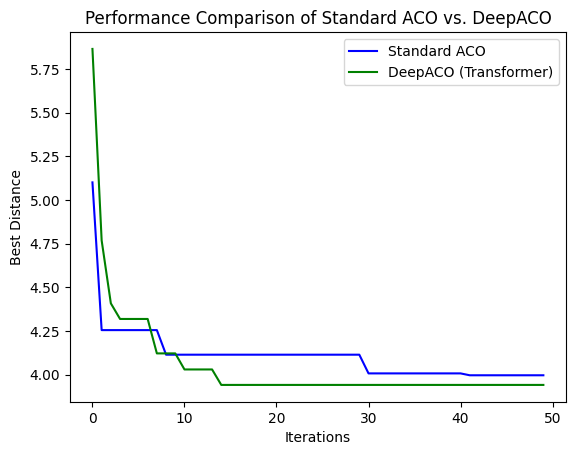

In [ ]:
import matplotlib.pyplot as plt

# Assuming we store best distances for each iteration in a list for both algorithms
standard_aco_distances = standard_aco.best_distances_per_iteration
deep_aco_distances = deep_aco.best_distances_per_iteration

plt.plot(standard_aco_distances, label="Standard ACO", color="blue")
plt.plot(deep_aco_distances, label="DeepACO (Transformer)", color="green")
plt.xlabel("Iterations")
plt.ylabel("Best Distance")
plt.legend()
plt.title("Performance Comparison of Standard ACO vs. DeepACO")
plt.show()
